In [1]:
# Importing Libraries

import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble, tree
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import confusion_matrix, auc,roc_auc_score,roc_curve,recall_score,classification_report
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)

# IMPORTING DATA

In [2]:
# Function to Load the file at specified path
# Parameters :- 1. path :- path from where file should be I

def Load_File(path) :
    if os.path.isfile(path) :
        data = pd.read_csv(path)
        data = data.replace('?', np.nan)
        print("\n" + "Number of rows in data are %s" % len(data))
        print("Number of columns in data are %s" % len(data.columns) + "\n")
        print("Following are the data types of columns:- ")
        print(data.dtypes)
        print("Number of missing values in the data are:- ")
        print(data.isnull().sum())
        print("Data Import is Complete")
        
        return data
    else:
        print(path + " does not exist. Enter the correct path")
        

# Generalized Function to plot the counts
# Parameters
# 1. rotx  : rotation of ticks on x-axis
# 2. roty  : rotation of ticks on y-axis
# 3. fontx : font size of ticks on x-axis
# 4. fonty : font size of ticks on y-axis
# 5. column_name : Name of the column for which we need the count
# 6. data_name   : Dataframe Used for plotting
# 7. plot_size   : Size of the plot
# 8. hue : If second column is needed for getting the count, the hue is True else False
# 9. hue_column_name = Second Column for plotting


def countplot(rotx, roty, fontx, fonty, column_name, data_name, plot_size = (10, 5), hue = False, hue_column_name=None):
    plt.figure(figsize = plot_size)
    plt.xticks(rotation=rotx, fontsize=fontx)
    plt.yticks(rotation=roty, fontsize=fonty)
    sns.set_style("whitegrid")
    if not hue:
        sns.countplot(column_name, data=data_name, palette='husl',
                      order = data_name[column_name].value_counts().index)
    else:
        sns.countplot(column_name, data=data_name, 
                      palette='husl', hue = hue_column_name,
                      order = data_name[column_name].value_counts().index)
    sns.despine()


# Function to Encode the Categorical Data Columns
# Parameters 1. df :- Dataframe 2. Column_name :- Feature to encode

def categorical_encoding(df, column_name_list=[]):
    
    for column_name in column_name_list:
        print(df[column_name].unique())
        categorical_columns = pd.get_dummies(df[column_name], prefix = column_name, 
                                             prefix_sep = '_', drop_first = False)
        df = pd.concat([df, categorical_columns], axis = 1)
        df = df.drop(column_name, axis = 1)
    return df


# Function to Label Encode the data
# Parameters :- 1. data :- Dataframe 2. columns_list :- List of columns to label encode

def labelEncoder(data, columns_list):
    for col in columns_list:
        encoder = LabelEncoder()
        data[col]  = encoder.fit_transform(data[col])
    return data


# Function to plot stacked plot
# Paramteres :- 
# data :- Dataframe used for plotting
# column_one :- Column One to group by
# column_two : Column Two to group by
# agg_column : Column to count numbers

def stacked_plot(data, column_one, column_two, agg_column, plot_size=(10, 5)):
    pal     = sns.color_palette("colorblind")
    grouped = data.groupby([column_one, column_two])[agg_column].count()
    grouped = grouped.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    grouped = grouped.unstack(column_two).fillna(0)
    print(grouped)
    unique_list = list(data[column_two].unique())
    grouped[unique_list].plot(kind='bar', stacked=True, color=pal, figsize=plot_size)

In [3]:
"""LOADING ASSESSMENTS DATA"""

# code_module          identification code of the module, to which the assessment belongs
# code_presentation    identification code of the presentation, to which the assessment belongs
# id_assessment        identification number of the assessment
# assessment_type      type of assessment
# date                 days information about the final submission date of the assessment calculated as the number of days 
#                      since the start of the module-presentation. The starting date of the presentation has number 0 (zero)
# weight               weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%
#                      the sum of all other assessments is 100%

oulad_assessment = Load_File('Desktop/OULAD/assessments.csv')


Number of rows in data are 206
Number of columns in data are 6

Following are the data types of columns:- 
code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                  object
weight               float64
dtype: object
Number of missing values in the data are:- 
code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64
Data Import is Complete


In [4]:
oulad_assessment.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19,10.0
1,AAA,2013J,1753,TMA,54,20.0
2,AAA,2013J,1754,TMA,117,20.0
3,AAA,2013J,1755,TMA,166,20.0
4,AAA,2013J,1756,TMA,215,30.0


In [5]:
### Filling in the missing values with the mean of the number of days.

oulad_assessment['date'] = oulad_assessment['date'].fillna(int(oulad_assessment['date'].astype(float).mean()))

In [6]:
### There are 7 types of code_module

oulad_assessment['code_module'].unique()

array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

In [7]:
### There are 3 types of Assessment
# TMA :- Tutor Marked Assessment
# CMA :- Computer Marked Assessment
# Exam :- Final Exam

oulad_assessment['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

(array([29., 25., 22., 34., 20., 32., 44.]),
 array([ 12.        ,  47.57142857,  83.14285714, 118.71428571,
        154.28571429, 189.85714286, 225.42857143, 261.        ]),
 <a list of 7 Patch objects>)

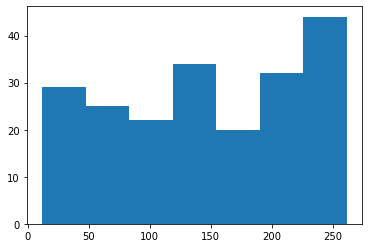

In [8]:
### Below histogram shows us the range of for the number for days for final submission.

plt.hist(oulad_assessment['date'].astype(int), bins=7)

In [9]:
"""Loading Courses Data"""

# code_module         name of the module, which serves as the identifier
# code_presentation   name of the presentation. It consists of the year and B for the presentation 
#                     starting in February and J for the presentation starting in October
# length              length of the module presentation in days

oulad_courses = Load_File('Desktop/OULAD/courses.csv')


Number of rows in data are 22
Number of columns in data are 3

Following are the data types of columns:- 
code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object
Number of missing values in the data are:- 
code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64
Data Import is Complete


In [10]:
oulad_courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [11]:
"""Loading Student Assessment Data"""

# id_assessment            the identification number of the assessment
# id_student               a unique identification number for the student
# date_submitted           the date of student submission, measured as the number of days 
#.                         since the start of the module presentation
# is_banked                a status flag indicating that the assessment result has been transferred from a previous presentation
# score                    the studentís score in this assessment. The range is from 0 to 100. The score lower than 40 is 
#                          interpreted as Fail. The marks are in the range from 0 to 100

oulad_student_assessment = Load_File('Desktop/OULAD/studentAssessment.csv')


Number of rows in data are 173912
Number of columns in data are 5

Following are the data types of columns:- 
id_assessment      int64
id_student         int64
date_submitted     int64
is_banked          int64
score             object
dtype: object
Number of missing values in the data are:- 
id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64
Data Import is Complete


In [12]:
### As the number of missing values are very less as compared to the total data

oulad_student_assessment = oulad_student_assessment.dropna()

In [13]:
oulad_student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78
1,1752,28400,22,0,70
2,1752,31604,17,0,72
3,1752,32885,26,0,69
4,1752,38053,19,0,79


In [14]:
"""Loading Student Registration Data"""

# code_module             an identification code for a module
# code_presentation       the identification code of the presentation
# id_student              a unique identification number for the student
# date_registration       the date of student's registration on the module presentation, this is the number of days measured relative to 
#                         the start of the module-presentation (e.g. the negative value -30 means that the student registered to module
#                         presentation 30 days before it started)
# date_unregistration     date of student unregistration from the module presentation, this is the number of days measured relative to 
#                         the start of the module-presentation. Students, who completed the course have this field empty. Students who 
#                         unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file

oulad_student_registration = Load_File('Desktop/OULAD/studentRegistration.csv')


Number of rows in data are 32593
Number of columns in data are 5

Following are the data types of columns:- 
code_module            object
code_presentation      object
id_student              int64
date_registration      object
date_unregistration    object
dtype: object
Number of missing values in the data are:- 
code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64
Data Import is Complete


In [15]:
## From the description it is clear that if value is missing in column date_unregistration then that means student
## completed the course and if it is null then student withdrawn from the course

## 0 : 'COMPLETED'
## 1 : 'WITHDRAWN'

## There are very few missing values in the data_registration column. I replaced it with the 0 

oulad_student_registration['date_unregistration'] = ['0' if pd.isnull(days) else '1' for days in oulad_student_registration['date_unregistration']]
oulad_student_registration['date_registration']   = oulad_student_registration['date_registration'].fillna(0).astype(float).apply(abs)


In [16]:
oulad_student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,159.0,0
1,AAA,2013J,28400,53.0,0
2,AAA,2013J,30268,92.0,1
3,AAA,2013J,31604,52.0,0
4,AAA,2013J,32885,176.0,0


In [17]:
"""Loading Student Information Data"""

# code_module             an identification code for a module on which the student is registered
# code_presentation       the identification code of the presentation during which the student is registered on the module
# id_student              a unique identification number for the student
# gender                  the studentís gender
# region                  identifies the geographic region, where the student lived while taking the module-presentation
# highest_education       highest student education level on entry to the module presentation
# imd_band                specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation
# age_band                band of the studentís age
# num_of_prev_attempts    the number times the student has attempted this module
# studied_credits         the total number of credits for the modules the student is currently studying
# disability              indicates whether the student has declared a disability
# final_result            studentís final result in the module-presentation

oulad_student_info = Load_File('Desktop/OULAD/studentInfo.csv')


Number of rows in data are 32593
Number of columns in data are 12

Following are the data types of columns:- 
code_module             object
code_presentation       object
id_student               int64
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
final_result            object
dtype: object
Number of missing values in the data are:- 
code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64
Data Import is Complete


In [18]:
### There are missing values in the imd_band. As those represent then band in which they are, we can think of them 
### like a category and we can fill missing values with the mode

print(oulad_student_info['imd_band'].unique())

oulad_student_info['imd_band'] = oulad_student_info['imd_band'].fillna(oulad_student_info['imd_band'].mode()[0])

['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' nan '60-70%'
 '40-50%' '10-20' '0-10%']


In [19]:
oulad_student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [20]:
# code_module           an identification code for a module
# code_presentation     the identification code of the module presentation
# id_student            a unique identification number for the student
# id_site               an identification number for the VLE material
# date                  the date of studentís interaction with the material measured as the 
#                       number of days since the start of the module-presentation
# sum_click             the number of times a student interacts with the material in that day 

oulad_student_vle = Load_File('Desktop/OULAD/studentVle.csv')


Number of rows in data are 10655280
Number of columns in data are 6

Following are the data types of columns:- 
code_module          object
code_presentation    object
id_student            int64
id_site               int64
date                  int64
sum_click             int64
dtype: object
Number of missing values in the data are:- 
code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64
Data Import is Complete


In [21]:
oulad_student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [22]:
"""Loading VLE data"""
# id_site              an identification number of the material
# code_module          an identification code for module
# code_presentation    the identification code of presentation
# activity_type        the role associated with the module material
# week_from            the week from which the material is planned to be used
# week_to              week until which the material is planned to be used

oulad_vle = Load_File('Desktop/OULAD/vle.csv')


Number of rows in data are 6364
Number of columns in data are 6

Following are the data types of columns:- 
id_site               int64
code_module          object
code_presentation    object
activity_type        object
week_from            object
week_to              object
dtype: object
Number of missing values in the data are:- 
id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64
Data Import is Complete


In [23]:
### As we can see that there are close to 80% values which are missing in the week_from and week_to columns
### So I will remove those columns

oulad_vle = oulad_vle.drop(['week_from', 'week_to'], axis = 1)

In [24]:
oulad_vle.head()

,id_site,code_module,code_presentation,activity_type
0,546943,AAA,2013J,resource
1,546712,AAA,2013J,oucontent
2,546998,AAA,2013J,resource
3,546888,AAA,2013J,url
4,547035,AAA,2013J,resource


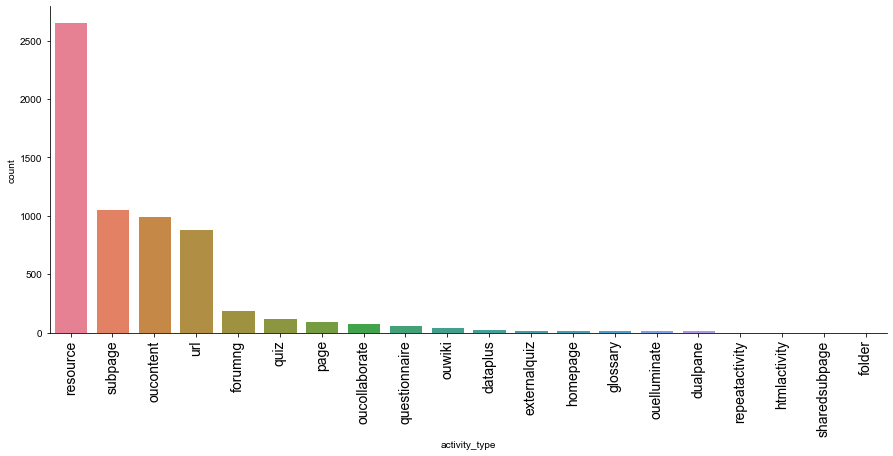

In [25]:
### We can see from the plot that activity_type = 'resource' has the most data points in VLE table

countplot(90, 0, 14, 10, 'activity_type', oulad_vle, plot_size=(15, 6))

# MERGING DATA

#### In this step we will merge different dataframe which we loaded in the previous steps. Based on the database schema we will 
#### join the different tables

Database schema.png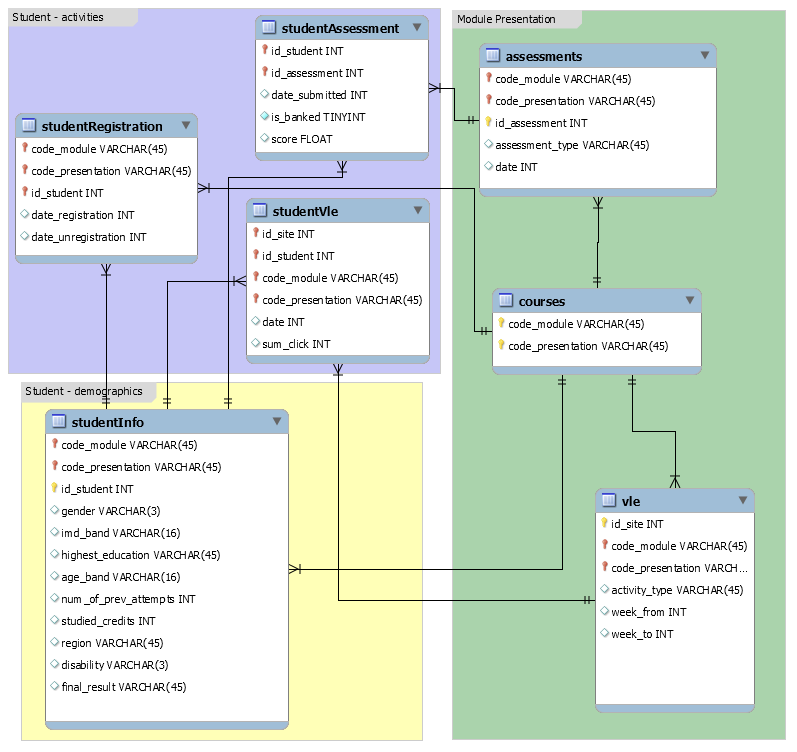

###### In the first step I am merging studentVle table with the vle table. This can show us about the interactions of students with VLE.

In [26]:
student_vle_merge_vle = oulad_student_vle.merge(oulad_vle, 
                                                on=['id_site', 'code_module', 'code_presentation'],
                                                how = 'left')

In [27]:
## We can see that there are multiple interactions from a single student even before the course started. We can assume
## that if student is interested in the course then that student will interact with the material of course before the
## course starts

## Number of clicks before the course can be an importtant factor which can help us determine whether student will
## perform good or bad in the course. Therefore for each student we will calculate the number of clicks before and
## after course went live

student_vle_merge_vle[(student_vle_merge_vle['id_student']==28400) & (student_vle_merge_vle['date']<0)].head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546614,-10,11,homepage
4,AAA,2013J,28400,546714,-10,1,oucontent
5,AAA,2013J,28400,546652,-10,8,forumng
6,AAA,2013J,28400,546876,-10,2,subpage
7,AAA,2013J,28400,546688,-10,15,oucontent
8,AAA,2013J,28400,546662,-10,17,oucontent
9,AAA,2013J,28400,546890,-10,1,url


In [28]:
student_vle_merge_vle['Click_Timing'] = ['Before' if date < 0 else 'After' for date in student_vle_merge_vle['date']]

In [29]:
# Creating After clicks and Before Clicks columns based on the data

student_vle_merge_vle['After_Clicks'] = np.where(student_vle_merge_vle['Click_Timing'] =='After',
                                                 student_vle_merge_vle['sum_click'], 0)

student_vle_merge_vle['Before_Clicks']= np.where(student_vle_merge_vle['Click_Timing'] =='Before',
                                                 student_vle_merge_vle['sum_click'], 0)

In [30]:
# Create a new dataframe by Grouping the columns

student_vle_merge_vle_group = student_vle_merge_vle.groupby(['code_module', 
                                                             'code_presentation', 
                                                             'id_student']
                                                            ,as_index=False)['sum_click', 'After_Clicks', 'Before_Clicks'].sum()

In [31]:
student_vle_merge_vle_group.isnull().sum()

code_module          0
code_presentation    0
id_student           0
sum_click            0
After_Clicks         0
Before_Clicks        0
dtype: int64

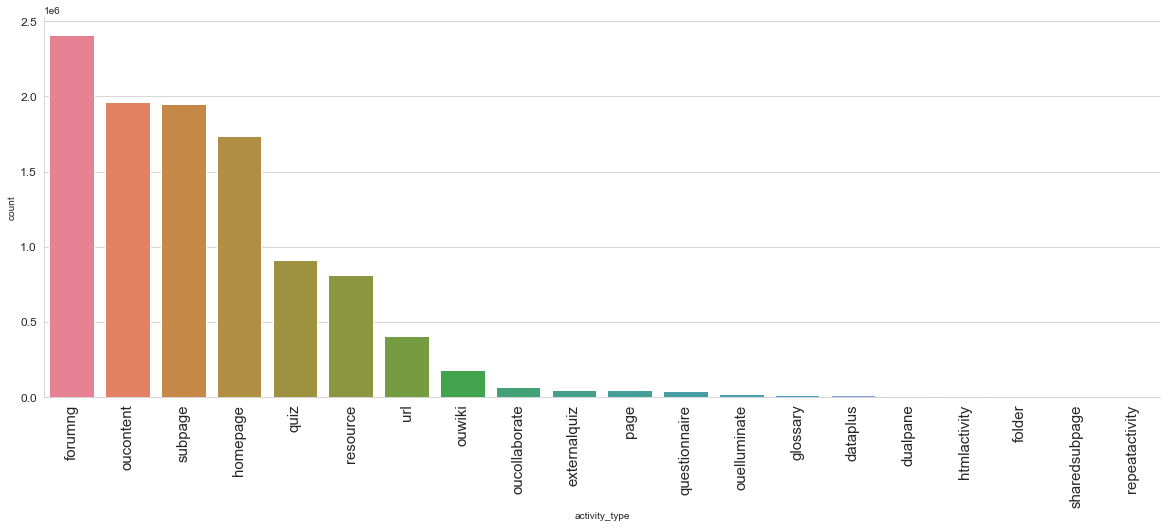

In [32]:
### Plot describing the way students connect to VLE
### We can see that most of the rows in the data are on ForumNG (Open University Forum Platform),
### oucontent (Open University Content), subpage and homepage.

countplot(90, 0, 15, 12, 'activity_type', student_vle_merge_vle, plot_size=(20, 7))

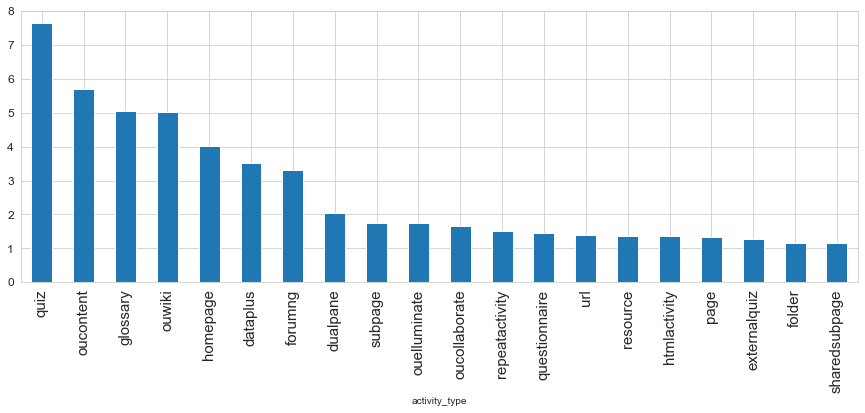

In [33]:
# In this step I am plotting average interaction of student with each activity type. 
# We can see that most of the interactions are with the QUIZ, OUCONTENT, GLOSSARY, OUWIKI which is understandable as 
# student interact mostly with content to learn stuff and then use glossary to understand the study material. Also,
# interactions with quiz is evident as after learning something, there are quizzes on the platform after completing chapters.

plt.figure(figsize = (15, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_vle_merge_vle.groupby(['activity_type'], as_index=True)['sum_click'].mean().sort_values(ascending=False).plot(kind='bar')


In [34]:
student_vle_merge_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,Click_Timing,After_Clicks,Before_Clicks
0,AAA,2013J,28400,546652,-10,4,forumng,Before,0,4
1,AAA,2013J,28400,546652,-10,1,forumng,Before,0,1
2,AAA,2013J,28400,546652,-10,1,forumng,Before,0,1
3,AAA,2013J,28400,546614,-10,11,homepage,Before,0,11
4,AAA,2013J,28400,546714,-10,1,oucontent,Before,0,1


###### In this step I will merge studentRegistration table with the courses table to understand the related between registrations and length of course

In [35]:
student_registration_merge_courses = oulad_student_registration.merge(oulad_courses, 
                                                                      on = ['code_module', 'code_presentation'],
                                                                      how = 'left')

In [36]:
student_registration_merge_courses['Year'] = student_registration_merge_courses['code_presentation'].str[0:4]
student_registration_merge_courses['Starting_Month'] = ['February' if code[-1] == 'B' else 'October' 
                                                        for code in student_registration_merge_courses['code_presentation']]

In [37]:
student_registration_merge_courses

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,Year,Starting_Month
0,AAA,2013J,11391,159.0,0,268,2013,October
1,AAA,2013J,28400,53.0,0,268,2013,October
2,AAA,2013J,30268,92.0,1,268,2013,October
3,AAA,2013J,31604,52.0,0,268,2013,October
4,AAA,2013J,32885,176.0,0,268,2013,October
...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,4.0,0,269,2014,October
32589,GGG,2014J,2645731,23.0,0,269,2014,October
32590,GGG,2014J,2648187,129.0,0,269,2014,October
32591,GGG,2014J,2679821,49.0,1,269,2014,October


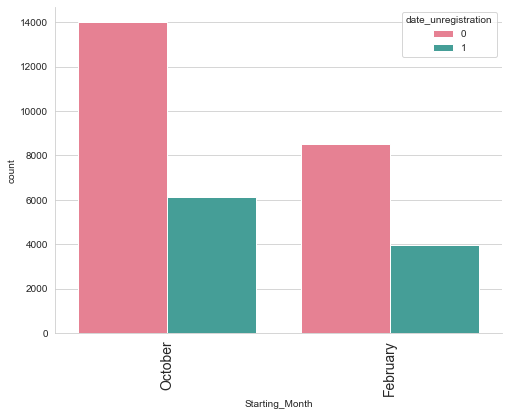

In [38]:
# We can clearly see from the below plot that mMore registrations are in the month of October as compared to the month
# of February. Also there are more people who drawn in the month of October.

countplot(90, 0, 14, 10, 'Starting_Month', student_registration_merge_courses, plot_size=(8, 6), hue=True, hue_column_name='date_unregistration')


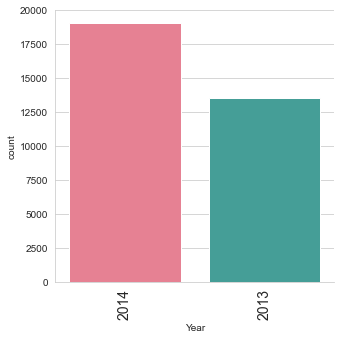

In [39]:
### This plot shows us that there are more registrations in 2014 as compared to 2013

countplot(90, 0, 14, 10, 'Year', student_registration_merge_courses, plot_size=(5, 5))

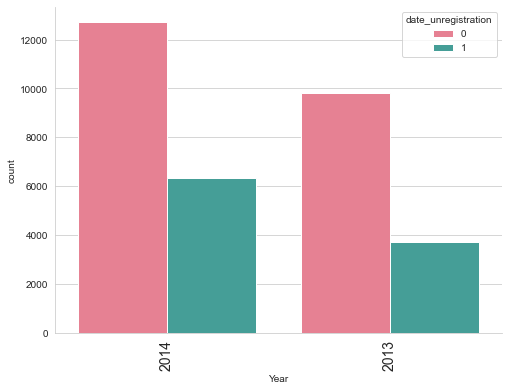

In [40]:
# This plot shows us the count by year and then by data unregistration count

countplot(90, 0, 14, 10, 'Year', student_registration_merge_courses, plot_size=(8, 6), hue=True, hue_column_name='date_unregistration')



In [41]:
### From the below table we can see that course length doesn't have much difference for the student who withdrawn
### and students who completed the course

student_registration_merge_courses.groupby('date_unregistration', as_index=False)['module_presentation_length'].mean()

,date_unregistration,module_presentation_length
0,0,256.095378
1,1,255.819500


###### In this step I will merge assessments Table with the studentAssessment Table to understand the relationship between assessment and student performance

In [42]:
student_assessment_merge_assessment = oulad_student_assessment.merge(oulad_assessment,
                                                                     on = ['id_assessment'], how='left' )

In [43]:
student_assessment_merge_assessment.dtypes

id_assessment          int64
id_student             int64
date_submitted         int64
is_banked              int64
score                 object
code_module           object
code_presentation     object
assessment_type       object
date                  object
weight               float64
dtype: object

In [44]:
# There would have been instances where students submitted their assignments later than the deadline. In this step,
# using the date_submitted (days after student recieved their assignment) column and date (deadline in days for the assignment)
# we can check whether their was a late submission or not (0 : Late, 1:OnTime)

student_assessment_merge_assessment['Late_submission'] = ['0' if int(student_assessment_merge_assessment['date_submitted'].iloc[i]) 
                                                          > int(student_assessment_merge_assessment['date'].iloc[i]) else '1' 
                                                         for i in range(len(student_assessment_merge_assessment))]


In [45]:
print('Percentage of Late Submissions From Students are : ')
print((len(student_assessment_merge_assessment[student_assessment_merge_assessment['Late_submission']=='0'])/len(student_assessment_merge_assessment)*100))
print('We can see that approximately 30 percent of students submitted their assigments late')

Percentage of Late Submissions From Students are : 
29.958155624240963
We can see that approximately 30 percent of students submitted their assigments late


Late_submission          0          1
assessment_type                      
CMA              46.777830  53.222170
Exam             57.914902  42.085098
TMA              16.473797  83.526203


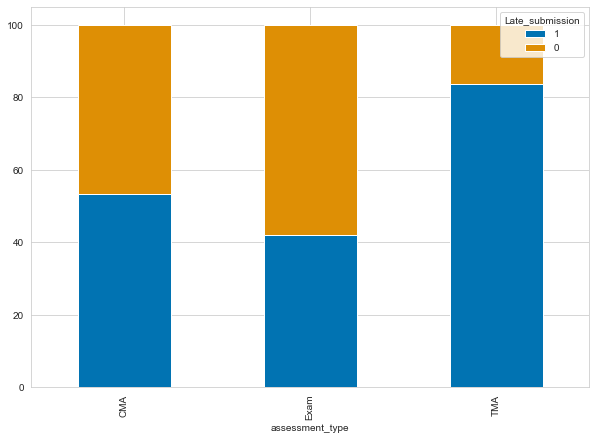

In [46]:
# There are three types of assessments :- Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA), Exams
# Following Plot Shows us the Percentage of Late Submission by Assessment_Type
# We can see that Most of the late submissions are for Final Exam and CMA which is Computer marked exam.
# Tutor marked exams has the least late submissions

stacked_plot(student_assessment_merge_assessment, 'assessment_type', 'Late_submission', 'id_student', plot_size=(10, 7))



Late_submission          0          1
code_module                          
AAA              25.810553  74.189447
BBB              47.472021  52.527979
CCC              69.063342  30.936658
DDD              30.566283  69.433717
EEE              14.544763  85.455237
FFF              10.345268  89.654732
GGG              10.049293  89.950707


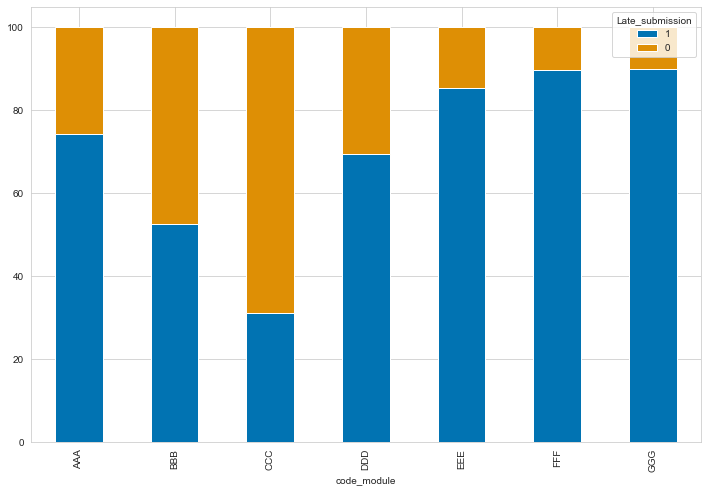

In [47]:
# There are 7 course modules. 4 are from STEM and 3 from Social Sciences
# Social Sciences :- AAA, BBB, GGG
# STEM :- CCC, DDD, EEE, FFF
# We can see from the plot that most percentage of the late submissions are for Course BBB, CCC and DDD


stacked_plot(student_assessment_merge_assessment, 'code_module', 'Late_submission', 'id_student', plot_size=(12, 8))

In [48]:
## Creating a column for Social Science and STEM field

student_assessment_merge_assessment['Code_Category'] = ['Social_Science' if student_assessment_merge_assessment['code_module'].iloc[i] in ['AAA', 'BBB', 'GGG']
                                                        else 'STEM' for i in range(len(student_assessment_merge_assessment))]


Late_submission          0          1
Code_Category                        
STEM             26.072296  73.927704
Social_Science   37.078578  62.921422


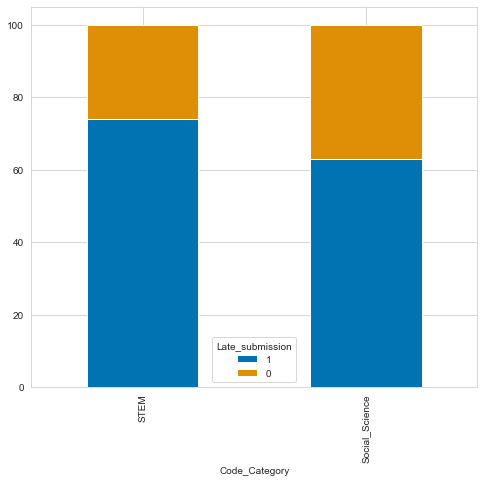

In [49]:
## Social Science has more percentage of late submissions as compared to STEM


stacked_plot(student_assessment_merge_assessment, 'Code_Category', 'Late_submission', 'id_student', plot_size=(8, 7))

In [50]:
# As from the description of table we know that score less than 40 is considered as Fail and above that is pass


student_assessment_merge_assessment['Result'] = ['Fail' if int(student_assessment_merge_assessment['score'].iloc[i]) < 40
                                                        else 'Pass' for i in range(len(student_assessment_merge_assessment))]

Result              Fail       Pass
Code_Category                      
STEM            5.132608  94.867392
Social_Science  2.949136  97.050864


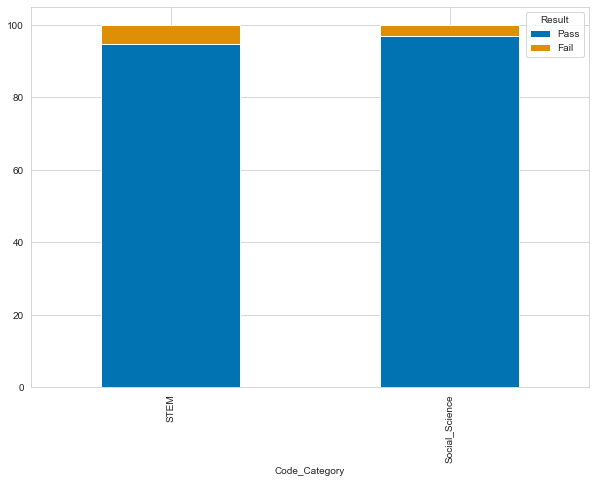

In [51]:
# Following Plot shows us the Ratio of Pass and Fail students in the form of plot
# Failure Rate in STEM is more as compared to Social Sciences

stacked_plot(student_assessment_merge_assessment, 'Code_Category', 'Result', 'id_student', plot_size=(10, 7))

Result           Fail       Pass
code_module                     
AAA          2.860776  97.139224
BBB          3.306266  96.693734
CCC          9.297903  90.702097
DDD          9.044297  90.955703
EEE          1.775298  98.224702
FFF          1.975570  98.024430
GGG          1.958593  98.041407


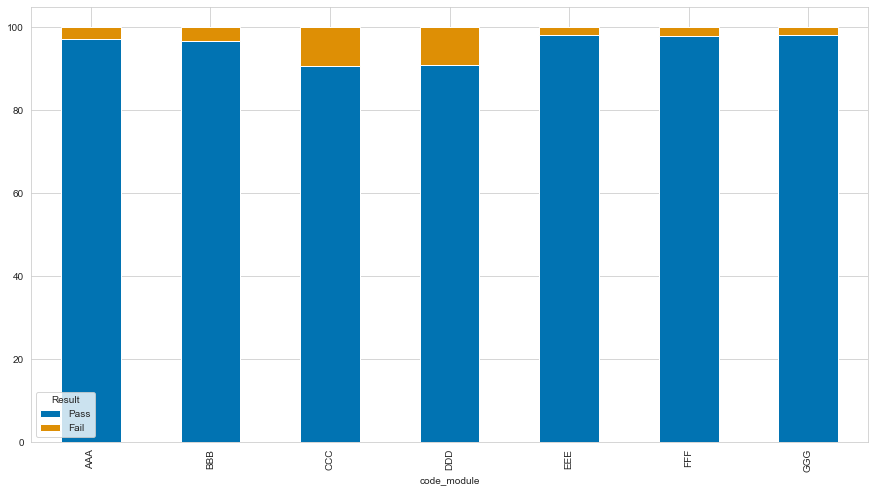

In [52]:
# We can see from the following plot that course DDD , CCC and BBB have the most failure rate. Out of the 3
# courses 2 of them are from STEM.


stacked_plot(student_assessment_merge_assessment, 'code_module', 'Result', 'id_student', plot_size=(15, 8))

In [53]:
## Weightage of Assignment can have impact on the submissions and Result of students. I categorized the weight into
## Low, Medium and High Weightage.

print(student_assessment_merge_assessment['weight'].unique())

percentage_segment = []

for percent in student_assessment_merge_assessment['weight']:
    if percent <= 10:
        percentage_segment.append('Low_Weightage')
    elif percent > 10 and percent <= 30:
        percentage_segment.append('Medium_Weightage')
    else:
        percentage_segment.append('High_Weightage')
        
student_assessment_merge_assessment['Weigthage'] = percentage_segment

[ 10.   20.   30.    5.   18.    1.    0.   35.    9.   22.    2.    7.
   8.  100.    7.5  12.5  15.    3.    4.    6.   17.5  25.   16.   28. ]


Result                Fail       Pass
Weigthage                            
High_Weightage    8.463783  91.536217
Low_Weightage     3.329021  96.670979
Medium_Weightage  5.307333  94.692667


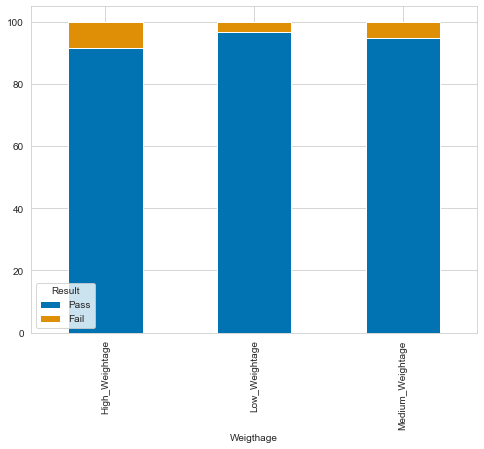

In [54]:
# We can see that Medium and High Weightage Assessments have high failure rate as compared to low

stacked_plot(student_assessment_merge_assessment, 'Weigthage', 'Result', 'id_student', plot_size=(8, 6))

Result               Fail       Pass
Late_submission                     
0                6.841630  93.158370
1                3.301011  96.698989


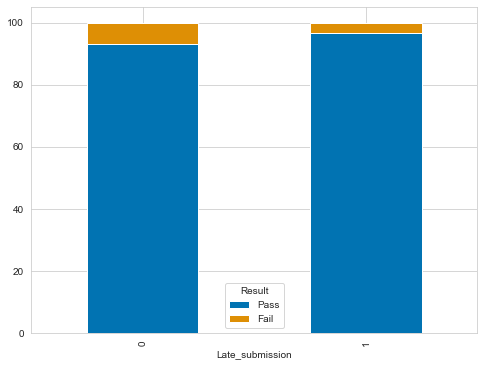

In [55]:
# Following Plot shows the ratio of Pass and Fail in Late_submission.
# We can clearly see that Late Submissions have more Failure Rate as compared to people who submit on time.

stacked_plot(student_assessment_merge_assessment, 'Late_submission', 'Result', 'id_student', plot_size=(8, 6))

In [56]:
student_assessment_merge_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,Late_submission,Code_Category,Result,Weigthage
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10.0,1,Social_Science,Pass,Low_Weightage
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10.0,0,Social_Science,Pass,Low_Weightage
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10.0,1,Social_Science,Pass,Low_Weightage
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10.0,0,Social_Science,Pass,Low_Weightage
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10.0,1,Social_Science,Pass,Low_Weightage


###### MERGING VLE DATA WITH THE STUDENT INFO DATA

In [57]:
student_info = oulad_student_info.merge(student_vle_merge_vle_group, 
                                        on = ['code_module', 'code_presentation', 'id_student'],
                                        how = 'left')

student_info['sum_click']     = student_info['sum_click'].fillna(student_info['sum_click'].mean())
student_info['After_Clicks']  = student_info['After_Clicks'].fillna(student_info['After_Clicks'].mean())
student_info['Before_Clicks'] = student_info['Before_Clicks'].fillna(student_info['Before_Clicks'].mean())

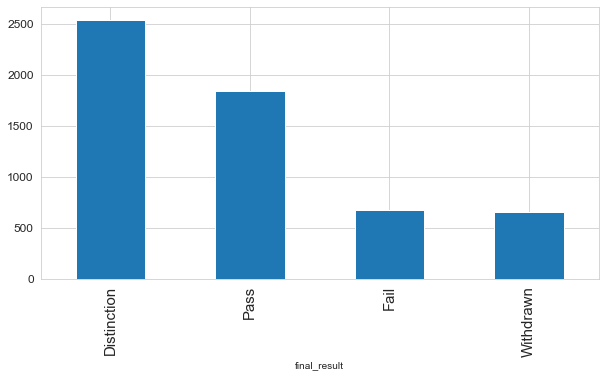

In [58]:
## In this plot I am trying to examine the relationship between number of clicks versus the result
## We can clearly see from the plot that number of clicks is directly related to the result. Student who passed with
## Distinction has significantly more clicks as compared to ones with result = PASS and there is a huge difference
## between the students who failed or withdrawn as compared to the one's who passed with or without distinction

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['final_result'])['After_Clicks'].mean().sort_values(ascending = False).plot(kind='bar')

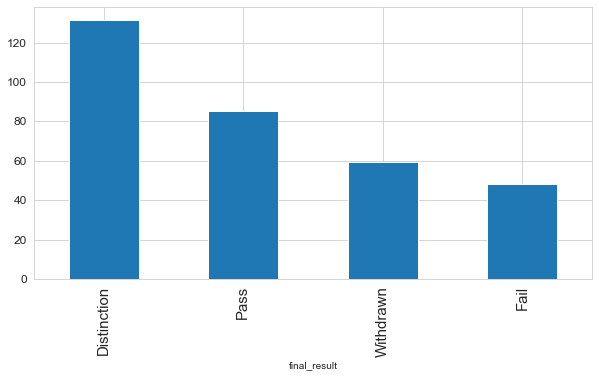

In [59]:
## Even from the clicks data before the course even started, we can see that more the clicks more are the chances
## for student to pass.

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['final_result'])['Before_Clicks'].mean().sort_values(ascending = False).plot(kind='bar')

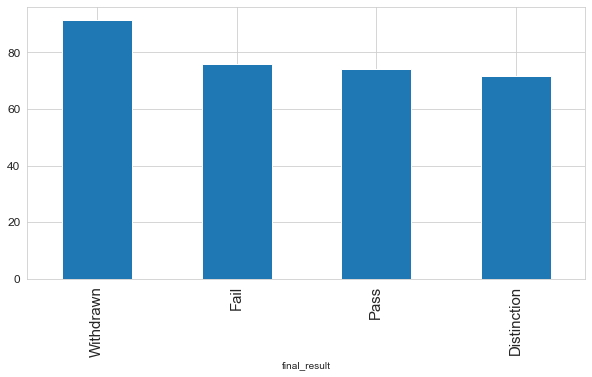

In [60]:
## People with less credits have more chances to pass with distinction or pass because they have to study less
## People who withdrew has more average credits as compared to another. 

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['final_result'])['studied_credits'].mean().sort_values(ascending = False).plot(kind='bar')

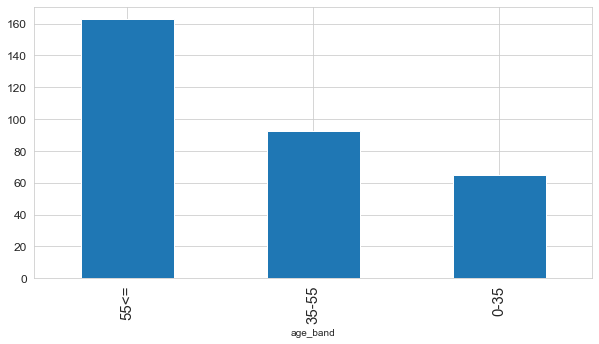

In [61]:
plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['age_band'])['Before_Clicks'].mean().sort_values(ascending = False).plot(kind='bar')

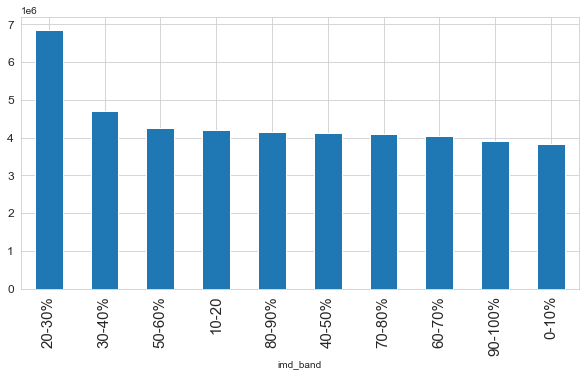

In [62]:
# Number of Clicks by imd_band.

plt.figure(figsize = (10, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['imd_band'])['sum_click'].sum().sort_values(ascending = False).plot(kind='bar')

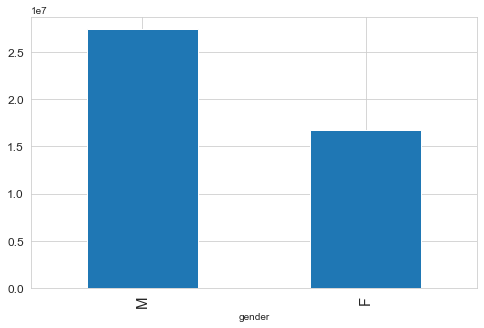

In [63]:
# We can see that Males have higher Click Rate as compared to the females

plt.figure(figsize = (8, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_info.groupby(['gender'])['sum_click'].sum().sort_values(ascending = False).plot(kind='bar')

age_band  final_result
0-35      Pass            8469
          Withdrawn       7381
          Fail            5231
35-55     Pass            3800
          Withdrawn       2721
0-35      Distinction     1863
35-55     Fail            1792
          Distinction     1120
55<=      Pass              92
          Withdrawn         54
          Distinction       41
          Fail              29
Name: id_student, dtype: int64
final_result  Distinction       Fail       Pass  Withdrawn
age_band                                                  
0-35             8.119770  22.798989  36.911611  32.169630
35-55           11.873211  18.997138  40.284109  28.845542
55<=            18.981481  13.425926  42.592593  25.000000


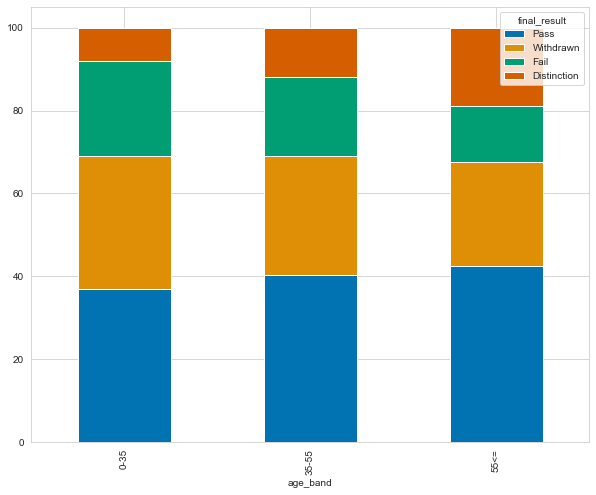

In [64]:
## Following plot shows us the number of students in each result category. Most of the data is in age band 0-55.
## There are very few data points for age >= 55. 
## We can see that Failure and Withdrawn rate is greater in age_band 0-35

print(student_info.groupby(['age_band', 'final_result'])['id_student'].count().sort_values(ascending = False))
stacked_plot(student_info, 'age_band', 'final_result', 'id_student', plot_size=(10, 8))

final_result                 Distinction       Fail       Pass  Withdrawn
highest_education                                                        
A Level or Equivalent          10.651477  19.273763  41.381274  28.693485
HE Qualification               14.735729  16.701903  41.437632  27.124736
Lower Than A Level              5.525156  26.037392  33.325733  35.111719
No Formal quals                 4.610951  27.377522  25.072046  42.939481
Post Graduate Qualification    28.115016  10.862620  37.380192  23.642173


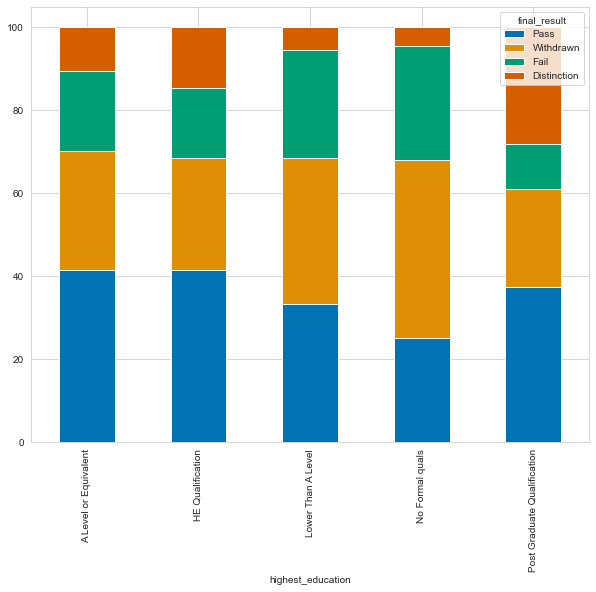

In [65]:
# We can see from the plot that Failure Rate and Withdrawal Rate is high in people who have NO FORMAL EDUCATION
# and who have LOWER THAN A LEVEL EDUCATION
# Failure Rate is lowest in people who has Post Graduation.


stacked_plot(student_info, 'highest_education', 'final_result', 'id_student', plot_size=(10, 8))

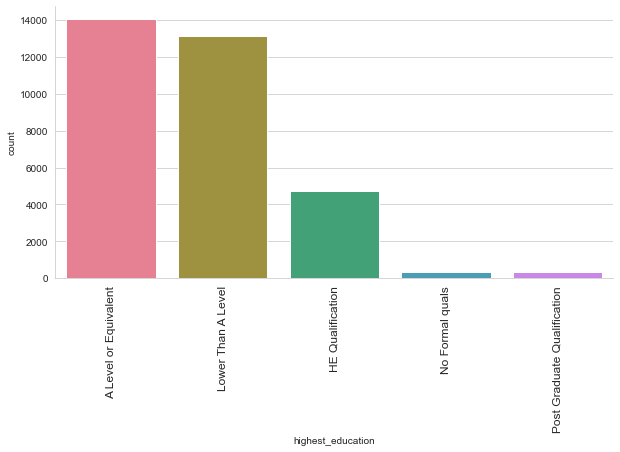

In [66]:
## We can see from the plot that most of the data is for people who have a level or lower level of education.
## This will cause an imbalance when the feature is used in the model. So I will manipulate the feature and 
## create two categories. One with higher education and one with lower education.

countplot(90, 0, 12, 10, 'highest_education', student_info)

In [67]:
student_info['highest_education'].unique()

array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
       'Post Graduate Qualification', 'No Formal quals'], dtype=object)

In [68]:
## Manioulating the feature higher_education

student_info['highest_education'] = [0 if education in ['A Level or Equivalent', 'Lower Than A Level', 'No Formal quals']
                                    else 1 for education in student_info['highest_education']]


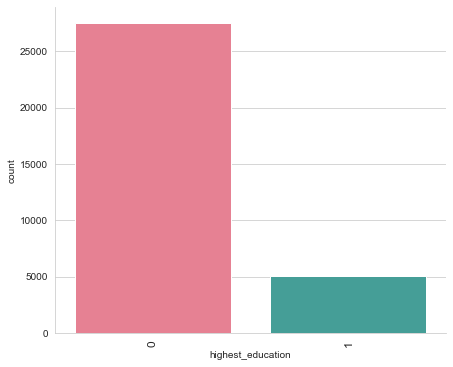

In [69]:
countplot(90, 0, 12, 10, 'highest_education', student_info, plot_size=(7, 6))

final_result       Distinction       Fail       Pass  Withdrawn
highest_education                                              
0                     8.127042  22.606171  37.328494  31.938294
1                    15.566131  16.339480  41.185802  26.908586


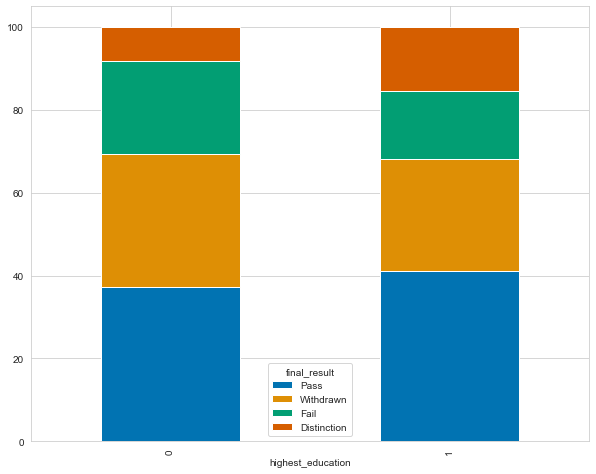

In [70]:
## We can see from the plot that students with lower education has higher failure rate than the ones who had higher education

stacked_plot(student_info, 'highest_education', 'final_result', 'id_student', plot_size=(10, 8))

final_result          Distinction       Fail       Pass  Withdrawn
region                                                            
East Anglian Region      9.790419  20.898204  39.191617  30.119760
East Midlands Region     8.456660  19.534884  37.251586  34.756871
Ireland                  8.277027  22.043919  46.621622  23.057432
London Region            8.177861  23.134328  34.172886  34.514925
North Region            12.616566  17.937466  37.904553  31.541415
North Western Region     7.329663  24.225740  32.863042  35.581555
Scotland                 9.518282  24.724318  39.437028  26.320371
South East Region       11.558503  17.764093  39.933681  30.743723
South Region            10.769728  17.593790  41.623545  30.012937
South West Region       10.837438  19.088670  38.957307  31.116585
Wales                    8.485139  29.721956  36.673058  25.119847
West Midlands Region     7.048799  21.340046  36.250968  35.360186
Yorkshire Region         8.225324  22.382851  36.640080  32.75

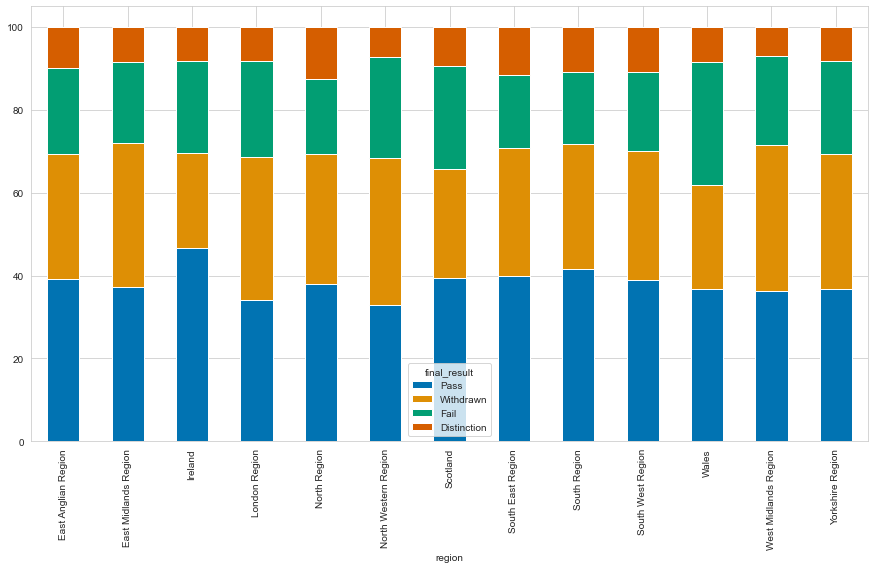

In [71]:
## We can see that Failure Rate and Withdrawal rate is similar in all the regions.

stacked_plot(student_info, 'region', 'final_result', 'id_student', plot_size=(15, 8))

final_result  Distinction       Fail       Pass  Withdrawn
imd_band                                                  
0-10%            5.073996  27.665358  30.081546  37.179100
10-20            5.432309  25.938567  33.191126  35.437998
20-30%           9.695698  20.755509  36.873033  32.675761
30-40%           8.900819  22.153151  38.005086  30.940944
40-50%           8.998771  21.406634  37.592138  32.002457
50-60%           9.507042  22.439181  39.276569  28.777209
60-70%          10.292599  18.519793  41.617900  29.569707
70-80%          10.871830  20.805835  40.639111  27.683223
80-90%          11.875453  17.921796  42.179580  28.023172
90-100%         14.116719  16.600946  43.414826  25.867508


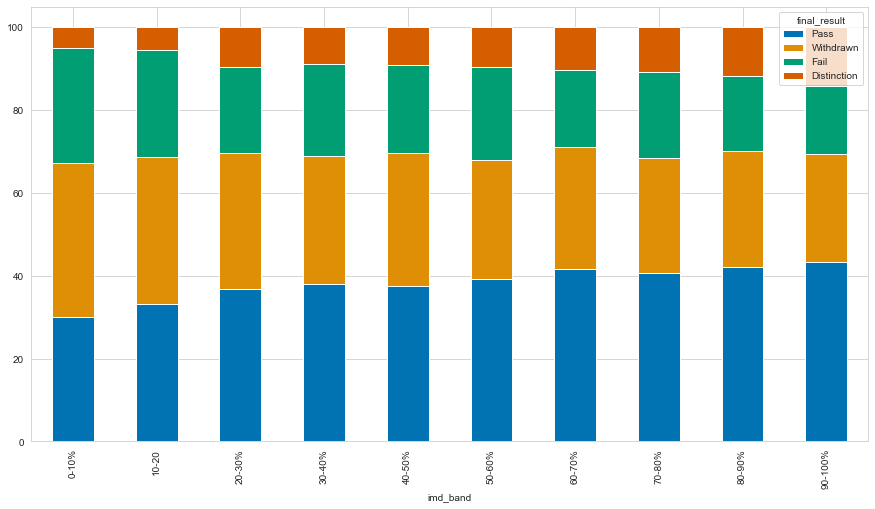

In [72]:
stacked_plot(student_info, 'imd_band', 'final_result', 'id_student', plot_size=(15, 8))

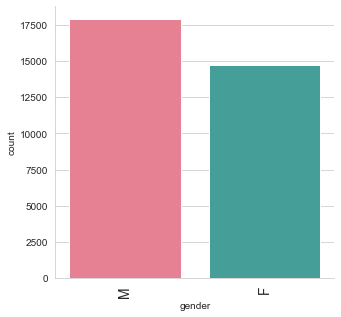

In [73]:
# We can see that Males are more in number as compared to females

countplot(90, 0, 14, 10, 'gender', student_info, plot_size=(5, 5))

final_result  Distinction       Fail       Pass  Withdrawn
gender                                                    
F                9.471396  21.083028  38.965892  30.479685
M                9.118881  22.092308  37.068531  31.720280


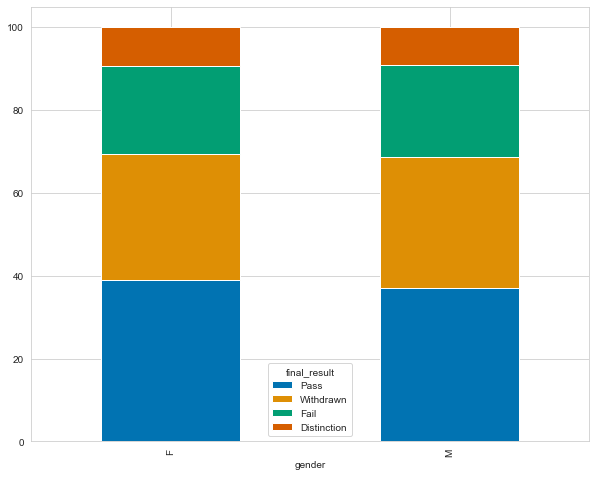

In [74]:
## We can see that there is no difference between the Withdrawal Rates and Failure Rates for both the gender.

stacked_plot(student_info, 'gender', 'final_result', 'id_student', plot_size=(10, 8))

final_result  Distinction       Fail       Pass  Withdrawn
disability                                                
N                9.517823  21.543376  38.659146  30.279656
Y                7.048040  22.503161  31.099874  39.348925


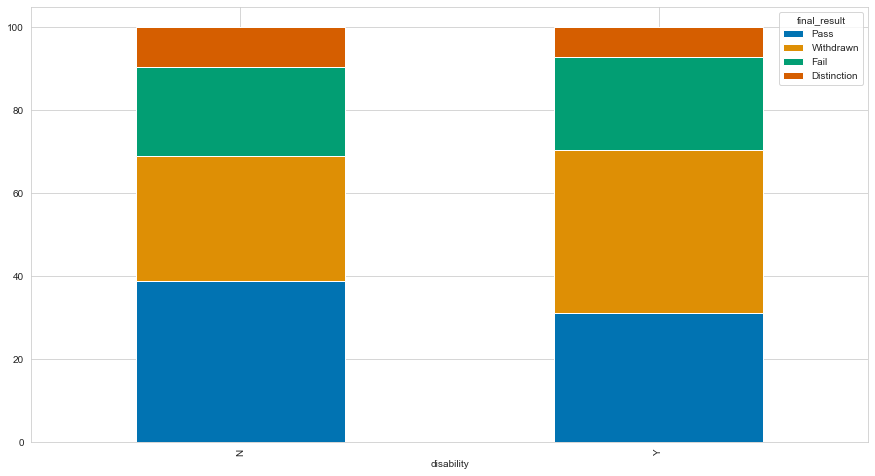

In [75]:
# Following plot shows us the results by disability.
# Withdrawn Rate is more in People who are disable.


stacked_plot(student_info, 'disability', 'final_result', 'id_student', plot_size=(15, 8))

###### Combining Student Info with the Student Registration Table

In [76]:
student_registration_merge_courses = student_registration_merge_courses.drop('date_unregistration', axis = 1)

In [77]:
student_info = student_info.merge(student_registration_merge_courses,
                                 on = ['code_module', 'code_presentation', 'id_student'],
                                 how = 'left')

final_result    Distinction       Fail       Pass  Withdrawn
Starting_Month                                              
February           8.896541  24.615631  34.769379  31.718450
October            9.515046  19.786123  39.885601  30.813231


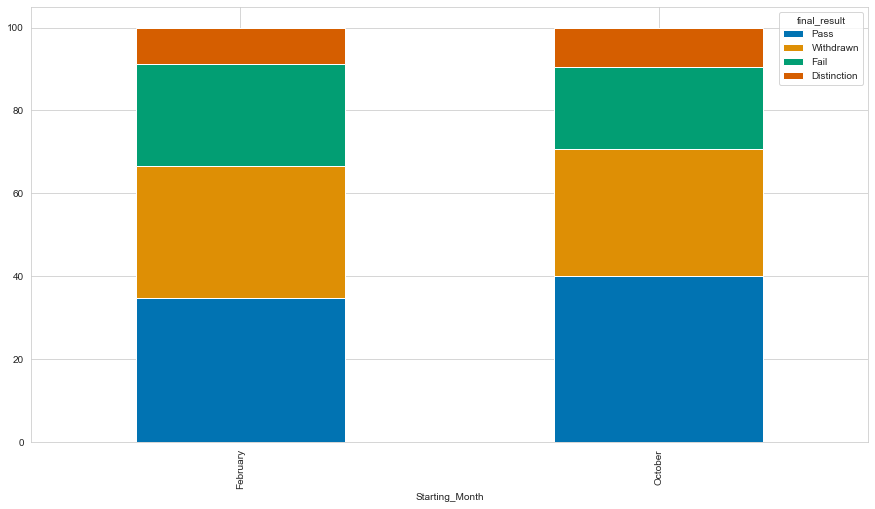

In [78]:
## Following Plot shows us the Result by Session. Failure Rate is more in people who took the course in February.
## Also withdrawn rate is slightly more in course starting in February. 

stacked_plot(student_info, 'Starting_Month', 'final_result', 'id_student', plot_size=(15, 8))

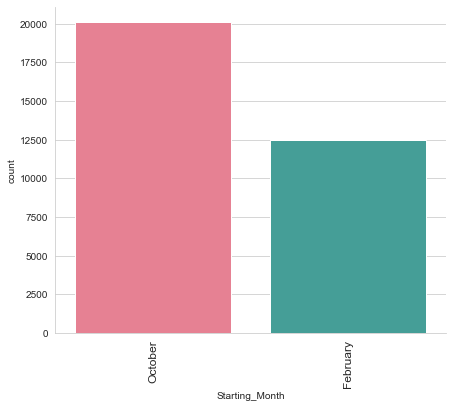

In [79]:
## There are less people who registered in February as compared to October. But still the failure and withdrawn rate
## is more for february. May be the students don't like content or the course in February.

countplot(90, 0, 12, 10, 'Starting_Month', student_info, plot_size=(7, 6))

final_result          Distinction       Fail       Pass  Withdrawn
num_of_prev_attempts                                              
0                       10.052426  20.164667  39.224517  30.558390
1                        4.334647  30.585026  30.221279  34.859048
2                        3.259259  34.962963  25.185185  36.592593
3                        0.704225  40.140845  21.830986  37.323944
4                        0.000000  30.769231  33.333333  35.897436
5                        0.000000  46.153846  15.384615  38.461538
6                       25.000000  25.000000   0.000000  50.000000


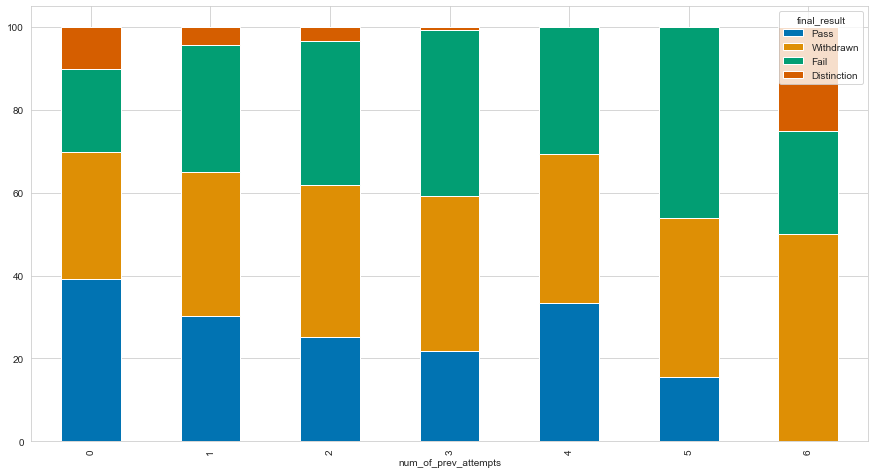

In [80]:
## We can clearly see from the plot that we have the least failure and withdrawn rate in the students who did not
## took the course before or number of previous attempts are zero. 

stacked_plot(student_info, 'num_of_prev_attempts', 'final_result', 'id_student', plot_size=(15, 8))


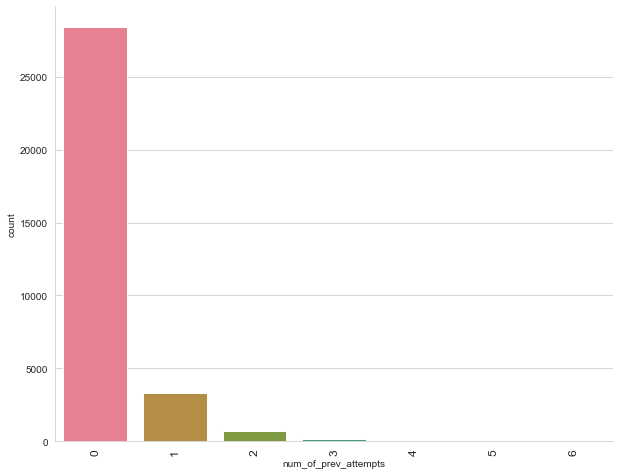

In [81]:
# Most of the data is for zero attempts which cause imbalance in the feature. We need to collect more data for creating
# balance in the feature. So instead of using this feature, we will manipulate the feature to create two categories only.
# 0 and 1 where 0 show no previous attempts and 1 shows previous attempts.

countplot(90, 0, 12, 10, 'num_of_prev_attempts', student_info, plot_size=(10, 8))

In [82]:
student_info['num_of_prev_attempts'] = [0 if attempts == 0 else 1 for attempts in student_info['num_of_prev_attempts']]

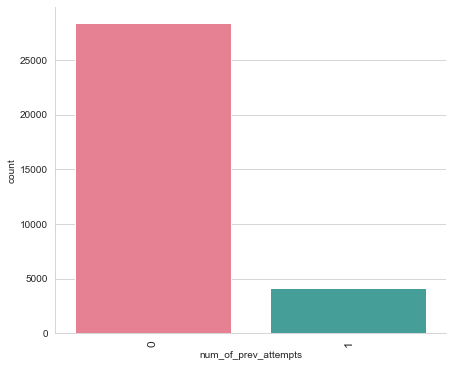

In [83]:
## Still there is imbalance in the feature but it's better than the initial.

countplot(90, 0, 12, 10, 'num_of_prev_attempts', student_info, plot_size=(7, 6))

final_result          Distinction       Fail       Pass  Withdrawn
num_of_prev_attempts                                              
0                       10.052426  20.164667  39.224517  30.558390
1                        4.002876  31.663471  29.074784  35.258869


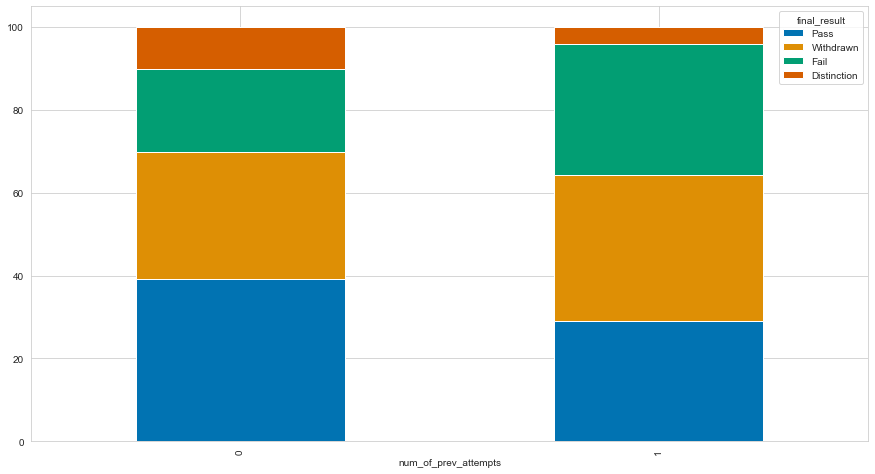

In [84]:
# We can clearly see that people with previous attempts have more failure and withdrawn rate.

stacked_plot(student_info, 'num_of_prev_attempts', 'final_result', 'id_student', plot_size=(15, 8))

final_result  Distinction       Fail       Pass  Withdrawn
code_module                                               
AAA              5.882353  12.165775  65.106952  16.844920
BBB              8.559869  22.341636  38.905045  30.193450
CCC             11.231394  17.613893  26.612539  44.542174
DDD              6.106505  22.512755  35.507015  35.873724
EEE             12.133606  19.154738  44.103613  24.608044
FFF              8.631796  22.043288  38.366400  30.958516
GGG             15.627466  28.729282  44.119968  11.523283


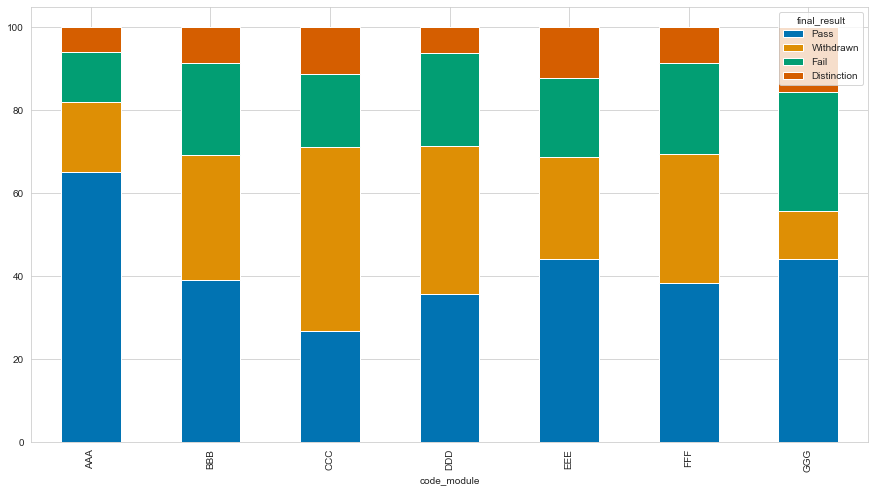

In [85]:
## We can see that 

stacked_plot(student_info, 'code_module', 'final_result', 'id_student', plot_size=(15, 8))

In [86]:
student_info['Code_Category'] = ['Social_Science' if student_info['code_module'].iloc[i] in ['AAA', 'BBB', 'GGG']
                                 else 'STEM' for i in range(len(student_info))]

final_result    Distinction       Fail       Pass  Withdrawn
Code_Category                                               
STEM               8.910382  20.867209  35.879824  34.342585
Social_Science     9.981235  23.107855  41.837191  25.073720


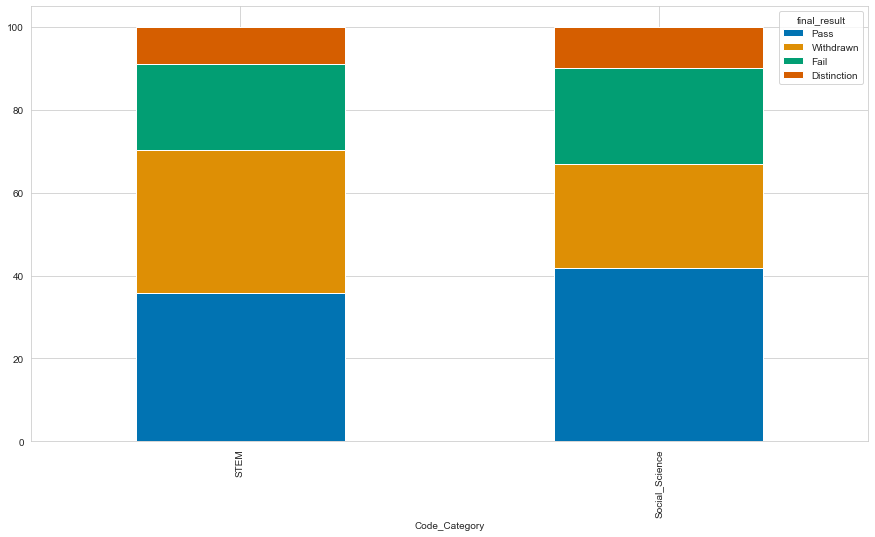

In [87]:
## From the following plot we can see that Failure Rate is higher in Social Science and Withdrawn rate is higher in
## STEM Courses.

stacked_plot(student_info, 'Code_Category', 'final_result', 'id_student', plot_size=(15, 8))

# DATA PREPARATION
#### Feature Selection
#### Data Encoding
#### Splitting Data

In [88]:
# In this step, I will remove code_module, code_presentation, id_student and Year as those won't have impact on the result 

student_info = student_info.drop(['code_presentation', 'id_student', 'Year'], axis = 1)

In [89]:
student_info['date_registration'] = student_info['date_registration'].astype(float)

In [90]:
student_info['date_registration'].describe()

count    32593.000000
mean        69.492437
std         49.044122
min          0.000000
25%         29.000000
50%         57.000000
75%        100.000000
max        322.000000
Name: date_registration, dtype: float64

In [91]:
student_info.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,After_Clicks,Before_Clicks,date_registration,module_presentation_length,Starting_Month,Code_Category
0,AAA,M,East Anglian Region,1,90-100%,55<=,0,240,N,Pass,934.0,836.0,98.0,159.0,268,October,Social_Science
1,AAA,F,Scotland,1,20-30%,35-55,0,60,N,Pass,1435.0,1220.0,215.0,53.0,268,October,Social_Science
2,AAA,F,North Western Region,0,30-40%,35-55,0,60,Y,Withdrawn,281.0,179.0,102.0,92.0,268,October,Social_Science
3,AAA,F,South East Region,0,50-60%,35-55,0,60,N,Pass,2158.0,1989.0,169.0,52.0,268,October,Social_Science
4,AAA,F,West Midlands Region,0,50-60%,0-35,0,60,N,Pass,1034.0,739.0,295.0,176.0,268,October,Social_Science


In [92]:
# There are two types of categorical variables in the data.
# 1. NOMINAL :- Here there is no order in the categories
# 2. ORDINAL :- When there is order in the category

nominal_columns = ['gender', 'region', 'disability', 'Starting_Month', 'code_module', 'Code_Category']
ordinal_columns = ['highest_education', 'imd_band', 'age_band']

In [93]:
data = labelEncoder(student_info, ordinal_columns)
data = categorical_encoding(student_info, nominal_columns)

['M' 'F']
['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']
['N' 'Y']
['October' 'February']
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['Social_Science' 'STEM']


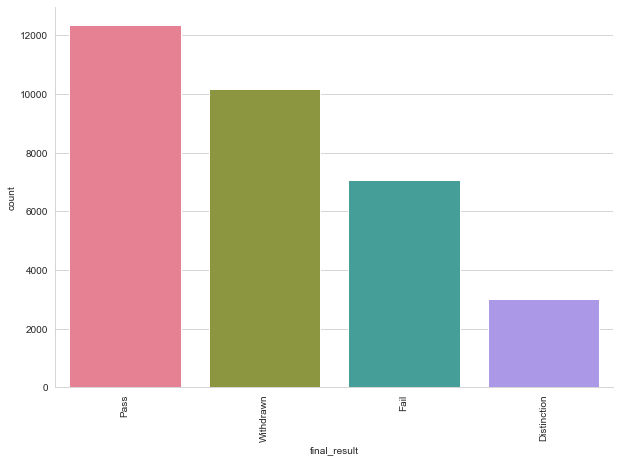

In [94]:
countplot(90, 0, 10, 10, 'final_result', data, plot_size=(10, 7))

### In the First case I am assuming Withdrawn Class as Fail and I am building a model whether student will pass or fail.
### In the Second case I will create a labels for dropout vs non-dropout and build a model using that

In [95]:
## To built a simplified binary class model, I am labeling Distinction and Pass as 0 and Withdrawn and Failure as 1

data['Result']  = [0 if result in ['Pass', 'Distinction'] else 1 for result in data['final_result']]

In [96]:
## In this steP, I am creating a dropout column where we consider withdrawn as the dropout and everything else as no dropout
## '0' : Not Withdrawn, '1': 'Withdrawn'

data['dropout'] = [0 if result in ['Pass', 'Distinction', 'Fail'] else 1 for result in data['final_result']]

In [97]:
## Creating Feature and Target Dataframes

feature = data.drop(['final_result', 'Result'], axis = 1)
target  = data['Result']

In [98]:
## We can see that both the classes are close in numbers. So I will treat this as a balanced case of binary classification.

target.value_counts()

1    17208
0    15385
Name: Result, dtype: int64

In [99]:
### Here we will split our data into training and testing. As we have less data, I will keep 80% of the data for 
### training and only 20% for testing. I would like to have more data where I can create three separate datasets
### for training, validation and testing. As our objective here is to find features which impact the decision whether
### student will fail or not, I will use most for training only.

X_train, X_test, Y_train, Y_test = train_test_split(feature, target, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify=data.final_result)

In [100]:
# In this step I will create a feature and target set for the dropout vs non-dropout case

feature_dropout = data.drop(['final_result', 'dropout', 'Result'], axis = 1)
target_dropout  = data['dropout']

In [101]:
target_dropout.value_counts()

0    22437
1    10156
Name: dropout, dtype: int64

In [102]:
## Splitting Data into training and test sets

X_train_dropout, X_test_dropout, Y_train_dropout, Y_test_dropout = train_test_split(feature_dropout, target_dropout, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 123, 
                                                                                    stratify=target_dropout)

In [103]:
data.head()

,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,final_result,sum_click,After_Clicks,Before_Clicks,date_registration,module_presentation_length,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y,Starting_Month_February,Starting_Month_October,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,Code_Category_STEM,Code_Category_Social_Science,Result,dropout
0,1,9,2,0,240,Pass,934.0,836.0,98.0,159.0,268,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
1,1,2,1,0,60,Pass,1435.0,1220.0,215.0,53.0,268,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
2,0,3,1,0,60,Withdrawn,281.0,179.0,102.0,92.0,268,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1
3,0,5,1,0,60,Pass,2158.0,1989.0,169.0,52.0,268,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,0,5,0,0,60,Pass,1034.0,739.0,295.0,176.0,268,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0


# BUILDING AND EVALUATING MODEL

#### Building a model to predict whether student will pass or fail

In [104]:
## Initializing the Random Forest Model

random_forest_model = RandomForestClassifier(n_estimators=100, 
                                             random_state=123, 
                                             max_depth=25,
                                             min_samples_split = 100,
                                             n_jobs=4)

In [105]:
## Fitting the model using Training Data

random_forest_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=25, min_samples_split=100, n_jobs=4,
                       random_state=123)

In [106]:
## Predicting on Test Data using fitted model

predictions_random = random_forest_model.predict(X_test)

In [107]:
print(confusion_matrix(Y_test, predictions_random))

[[2918  159]
 [ 506 2936]]


In [108]:
print("Accuracy of the model is ", accuracy_score(Y_test, predictions_random))

Accuracy of the model is  0.8979904893388556


In [109]:
print(classification_report(Y_test, predictions_random, digits=2))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      3077
           1       0.95      0.85      0.90      3442

    accuracy                           0.90      6519
   macro avg       0.90      0.90      0.90      6519
weighted avg       0.90      0.90      0.90      6519



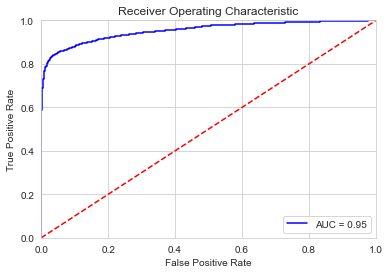

In [110]:
predictions_rf = random_forest_model.predict_proba(X_test)
preds = predictions_rf[:,1]
y_test = np.array(Y_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### USING GRID SEARCH FOR HYPERPARAMETER OPTIMIZATION

In [111]:
# n_estimators      = [100, 300, 500, 800, 1200]
# max_depth         = [5, 8, 15, 25, 30]
# min_samples_split = [50, 100, 150, 250, 300]
# min_samples_leaf  = [1, 2, 5, 10] 

# hyperF  = {'n_estimators' : n_estimators, 
#            'max_depth' : max_depth,  
#            'min_samples_split' : min_samples_split, 
#            'min_samples_leaf' : min_samples_leaf}

# gridF   = GridSearchCV(random_forest_model, hyperF, cv = 3, verbose = 1)
# bestF   = gridF.fit(X_train, Y_train)

In [112]:
# bestF.best_params_

# {'max_depth': 30,
#  'min_samples_leaf': 1,
#  'min_samples_split': 50,
#  'n_estimators': 100}

In [113]:
random_forest_model_best_fit = RandomForestClassifier(n_estimators=100, 
                                                      random_state=123, 
                                                      max_depth=30,
                                                      min_samples_split = 50,
                                                      n_jobs=4)

In [114]:
random_forest_model_best_fit.fit(X_train, Y_train)

RandomForestClassifier(max_depth=30, min_samples_split=50, n_jobs=4,
                       random_state=123)

In [115]:
predict_best_fit = random_forest_model_best_fit.predict(X_test)

In [116]:
print(classification_report(predict_best_fit, Y_test))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      3424
           1       0.85      0.95      0.90      3095

    accuracy                           0.90      6519
   macro avg       0.90      0.90      0.90      6519
weighted avg       0.90      0.90      0.90      6519



In [117]:
## We can see that region has close to None impact on the output of the model. So we will remove this feature.

importance = pd.concat([pd.DataFrame(X_train.columns),
                          pd.DataFrame(np.transpose(random_forest_model.feature_importances_))], axis = 1)
importance.columns = ['Features', 'Coeff']
importance = importance.sort_values('Coeff', ascending=False)
importance

,Features,Coeff
38,dropout,0.351216
6,After_Clicks,0.245894
5,sum_click,0.217119
7,Before_Clicks,0.058357
34,code_module_FFF,0.019404
37,Code_Category_Social_Science,0.012351
36,Code_Category_STEM,0.012193
4,studied_credits,0.011334
1,imd_band,0.010093
8,date_registration,0.007599


#### Building a model to predict whether student will dropout or not

In [118]:
## I am using class weight in this case because we have less samples for class = 1 which is dropout

random_forest_model_drop = RandomForestClassifier(n_estimators=100, 
                                                  random_state=123, 
                                                  max_depth=25,
                                                  min_samples_split = 100,
                                                  class_weight = {0: 1, 1: 2},
                                                  n_jobs=4)

In [119]:
random_forest_model_drop.fit(X_train_dropout, Y_train_dropout)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=25,
                       min_samples_split=100, n_jobs=4, random_state=123)

In [120]:
predict_dropout = random_forest_model_drop.predict(X_test_dropout)

In [121]:
print(classification_report(predict_dropout, Y_test_dropout))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4102
           1       0.80      0.67      0.73      2417

    accuracy                           0.82      6519
   macro avg       0.81      0.79      0.80      6519
weighted avg       0.82      0.82      0.81      6519



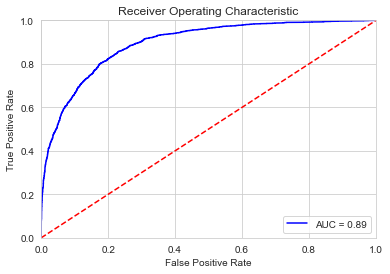

In [122]:
predictions_rf = random_forest_model_drop.predict_proba(X_test_dropout)
preds = predictions_rf[:,1]
y_test = np.array(Y_test_dropout)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [123]:
importance = pd.concat([pd.DataFrame(X_train_dropout.columns),
                          pd.DataFrame(np.transpose(random_forest_model_drop.feature_importances_))], axis = 1)
importance.columns = ['Features', 'Coeff']
importance = importance.sort_values('Coeff', ascending=False)
importance

,Features,Coeff
6,After_Clicks,0.341960
5,sum_click,0.303304
7,Before_Clicks,0.124920
4,studied_credits,0.034788
8,date_registration,0.024408
36,Code_Category_STEM,0.021686
37,Code_Category_Social_Science,0.021497
35,code_module_GGG,0.017961
34,code_module_FFF,0.014039
9,module_presentation_length,0.011269
